In [138]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from pydpmd.data.bumpy_utils import get_bumpy_dists
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function, compute_angle_pair_correlation_function, compute_angle_simple_pair_correlation_function
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm
from scipy.signal import savgol_filter
from scipy.optimize import minimize

def obj(b, x, y):
    return np.sum((y - (x[:, None] + b)) ** 2)

In [144]:
root = '/home/mmccraw/dev/data/09-27-25/run-1/'
R = re.compile(rf'^dynamics_(\d+)$')
ds = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d)) and R.fullmatch(d)]
run_names = [os.path.join(root,d) for d in sorted(ds,key=lambda s:int(R.fullmatch(s).group(1)))]

n_tol = 0.2

x = []
y_small = []
y_large = []
z = []
c = []
p = []
o = []
inner_small = []
inner_large = []
diff = []
diff_n = []
diff_R = []
diff_R_n = []

for run_name in run_names:
    try:
        data = load(run_name, location=['final', 'init'], load_trajectory=True, load_full=False)
        data.calculate_mu_eff()
    except:
        continue
    msd_path = os.path.join(run_name, 'msd.npz')
    msd, t = compute_rotational_msd(data, msd_path, overwrite=False)
    shear_modulus_path = os.path.join(run_name, 'shear_modulus.npz')
    shear_modulus, t = compute_shear_modulus(data, shear_modulus_path, overwrite=False, subtract_mean_stress=True)
    pair_correlation_function_path = os.path.join(run_name, 'pair_correlation_function.npz')
    radial_bins = np.linspace(0.5, 3, 1000)
    G, r = compute_pair_correlation_function(data, radial_bins, pair_correlation_function_path)
    # angle_simple_pair_correlation_function_path = os.path.join(run_name, 'angle_simple_pair_correlation_function.npz')
    # if not os.path.exists(angle_simple_pair_correlation_function_path):
    #     continue
    # G_delta, t = compute_angle_simple_pair_correlation_function(data, angle_simple_pair_correlation_function_path)
    # angle_pair_correlation_function_path = os.path.join(run_name, 'angle_pair_correlation_function.npz')
    # G_delta, r, t = compute_angle_pair_correlation_function(data, radial_bins, angle_pair_correlation_function_path, overwrite=False)

    pressure = np.mean([data.trajectory[i].pressure for i in range(data.trajectory.num_frames())], axis=0)
    te = np.array([data.trajectory[i].pe_total + data.trajectory[i].ke_total for i in range(data.trajectory.num_frames())])
    te_fluc = np.std(te, axis=0) / np.mean(te, axis=0)
    phi = data.packing_fraction

    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=0, vmax=len(phi))
    mu_norm = LogNorm(vmin=min(data.mu_eff), vmax=max(data.mu_eff))

    # plt.scatter(data.mu_eff[data.system_offset[:-1]], r[np.argmax(G, axis=-1)][:, 0], c=cmap(norm(phi)))
    # plt.scatter(phi, r[np.argmax(G, axis=-1)][:, 0], c=cmap(mu_norm(data.mu_eff[data.system_offset[:-1]])))
    x.append(phi)

    mask = G > (np.max(G, axis=-1) * 0.95)[..., None]
    r0 = np.sum(mask * r[None, None, :], axis=-1) / np.sum(mask, axis=-1)

    y_small.append(r[np.argmax(G, axis=-1)][:, 0])  # naive way
    # y_small.append(r0[:, 0])  # sligthly more advanced
    
    y_large.append(r[np.argmax(G, axis=-1)][:, 1])  # naive way
    # y_large.append(r0[:, 1])  # slightly more advanced
    
    z.append(data.n_vertices_per_particle[data.system_offset[:-1]])
    c.append(data.mu_eff[data.system_offset[:-1]])
    p.append(pressure)
    o.append(np.mean([data.trajectory[i].pe_total for i in range(data.trajectory.num_frames())], axis=0) / data.system_size)
    
    vertex_diam = data.vertex_rad[data.vertex_system_offset[:-1]] * 2
    
    vertex_spacing_small = np.linalg.norm(data.vertex_pos[data.vertex_system_offset[:-1]] - data.vertex_pos[data.vertex_system_offset[:-1] + 1], axis=-1)
    diam_small = data.rad[data.system_offset[:-1]] * 2
    num_vertices_small = data.n_vertices_per_particle[data.system_offset[:-1]]
    outer_mask_small = vertex_diam > vertex_spacing_small
    d_0_small, d_min_small = get_bumpy_dists(num_vertices_small, diam_small / 2.0, vertex_diam / 2.0)
    inner_diam_small = d_min_small
    inner_diam_small[~outer_mask_small] = ((diam_small - vertex_diam)[~outer_mask_small] + diam_small[~outer_mask_small]) / 2.0
    inner_small.append(inner_diam_small)

    vertex_spacing_large = np.linalg.norm(data.vertex_pos[data.vertex_system_offset[1:]-2] - data.vertex_pos[data.vertex_system_offset[1:]-1], axis=-1)
    diam_large = data.rad[data.system_offset[1:]-1] * 2
    num_vertices_large = data.n_vertices_per_particle[data.system_offset[1:]-1]
    outer_mask_large = vertex_diam > vertex_spacing_large
    d_0_large, d_min_large = get_bumpy_dists(num_vertices_large, diam_large / 2.0, vertex_diam / 2.0)
    inner_diam_large = d_min_large
    inner_diam_large[~outer_mask_large] = ((diam_large - vertex_diam)[~outer_mask_large] + diam_large[~outer_mask_large]) / 2.0
    inner_large.append(inner_diam_large)

    Y = np.log10(msd)
    X = np.log10(t)
    n, D_simple = np.polyfit(X, Y[:, :, 0], 1)
    D_simple = 10 ** D_simple

    n_R, D_R_simple = np.polyfit(X, Y[:, :, 1], 1)
    D_R_simple = 10 ** D_R_simple

    mask = X > X.max() - 1
    b_guess = np.ones(Y.shape[1]) * -3
    b = minimize(obj, b_guess, args=(X[mask], Y[mask, :, 0])).x
    D = 10 ** b
    D[np.abs(n - 1) > n_tol] = np.nan

    b = minimize(obj, b_guess, args=(X[mask], Y[mask, :, 1])).x
    D_R = 10 ** b
    D_R[np.abs(n_R - 1) > n_tol] = np.nan

    diff.append(D)
    diff_n.append(n)
    diff_R.append(D_R)
    diff_R_n.append(n_R)

    # if phi[24] > 0.81:
    #     break

    # plt.plot(r, G[1, 0])
    # plt.plot(r, G[21, 0])
    # if phi[1] > 0.75:
        # break

#     for i in range(len(phi)):
#         plt.scatter(phi[i], te_fluc[i], c=cmap(norm(i)))
# plt.yscale('log')

#     for i in range(len(phi)):
#         plt.scatter(phi[i], pressure[i], c=cmap(norm(i)))
# plt.yscale('log')

x = np.array(x)
y_small = np.array(y_small)
y_large = np.array(y_large)
z = np.array(z)
c = np.array(c)
p = np.array(p)
o = np.array(o)
inner_small = np.array(inner_small)
inner_large = np.array(inner_large)

diff_n = np.array(diff_n)
diff_R_n = np.array(diff_R_n)
diff = np.array(diff)
diff_R = np.array(diff_R)



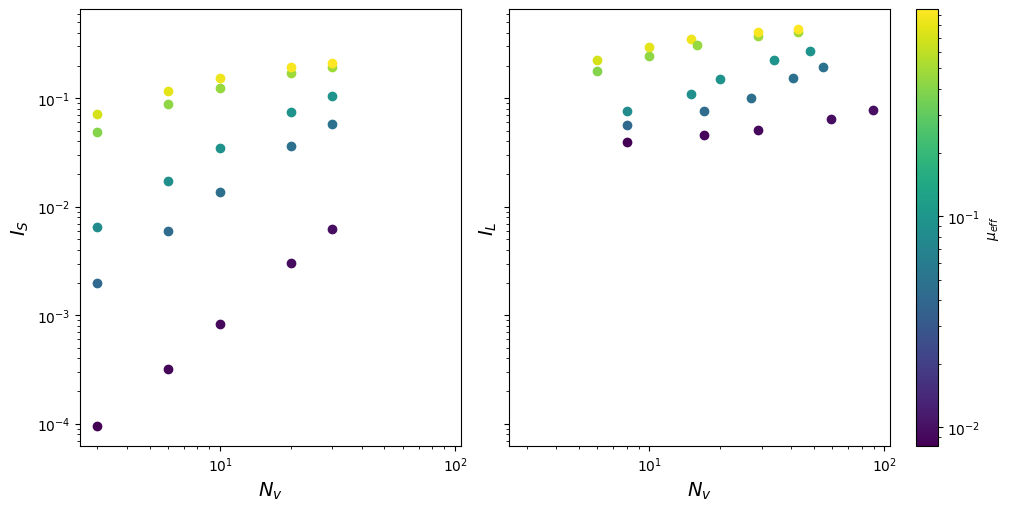

In [82]:
data.calculate_mu_eff()
nv_large = data.n_vertices_per_particle[data.system_offset[1:]-1]
nv_small = data.n_vertices_per_particle[data.system_offset[:-1]]
I_large = data.moment_inertia[data.system_offset[1:]-1]
I_small = data.moment_inertia[data.system_offset[:-1]]
mu_eff = data.mu_eff[data.system_offset[:-1]]
fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True, sharey=True, sharex=True)
for n in np.unique(nv_small):
    for mu in np.unique(mu_eff):
        mask = (nv_small == n) & (mu_eff == mu)
        if np.sum(mask) == 0:
            continue
        for _ in I_small[mask]:
            ax[0].scatter(n - 1, _, color=cmap(mu_norm(mu)))
for n in np.unique(nv_large):
    for mu in np.unique(mu_eff):
        mask = (nv_large == n) & (mu_eff == mu)
        if np.sum(mask) == 0:
            continue
        for _ in I_large[mask]:
            ax[1].scatter(n - 1, _, color=cmap(mu_norm(mu)))
ax[0].set_ylabel(r'$I_{S}$', fontsize=14)
ax[1].set_ylabel(r'$I_{L}$', fontsize=14)
for a in ax:
    a.set_yscale('log')
    a.set_xscale('log')
    a.set_xlabel(r'$N_v$', fontsize=14)
sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
sm.set_array(np.unique(mu_eff))
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
plt.show()


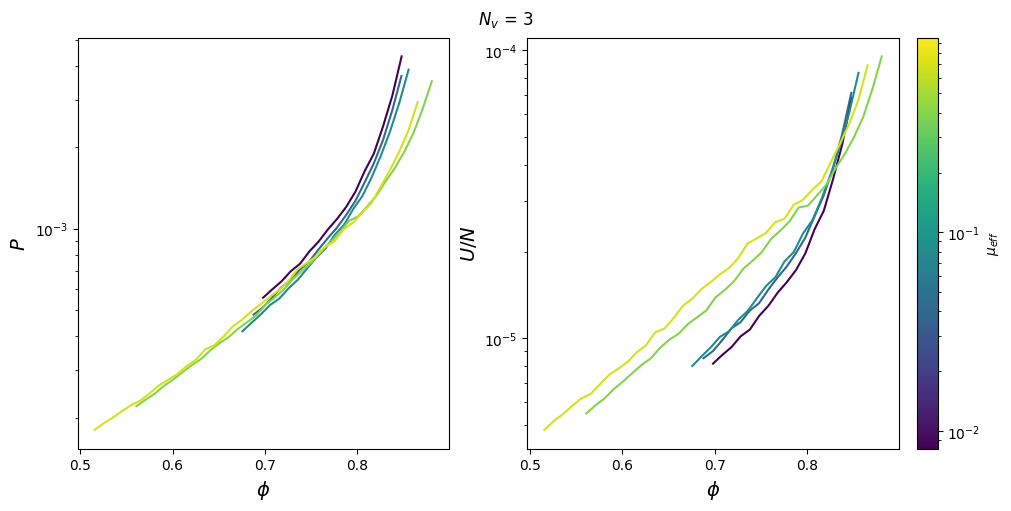

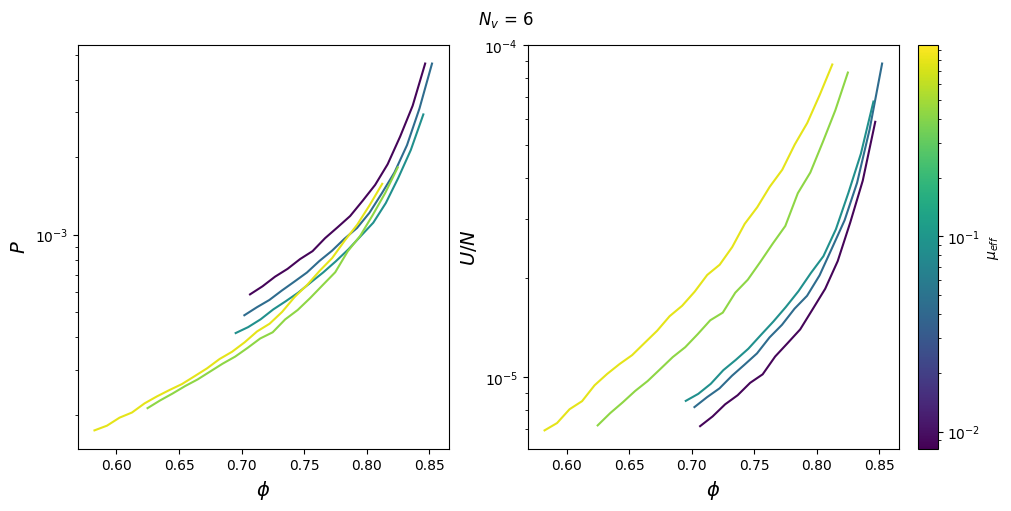

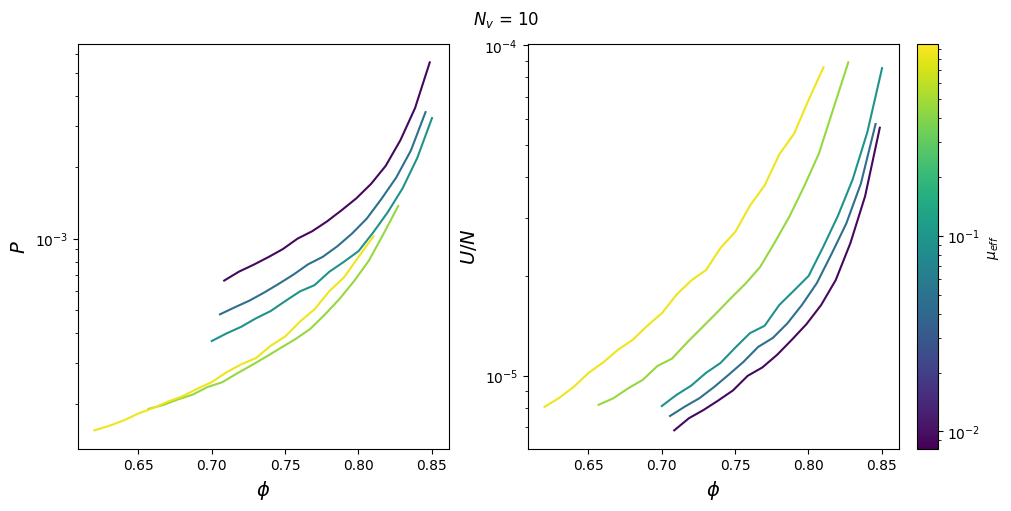

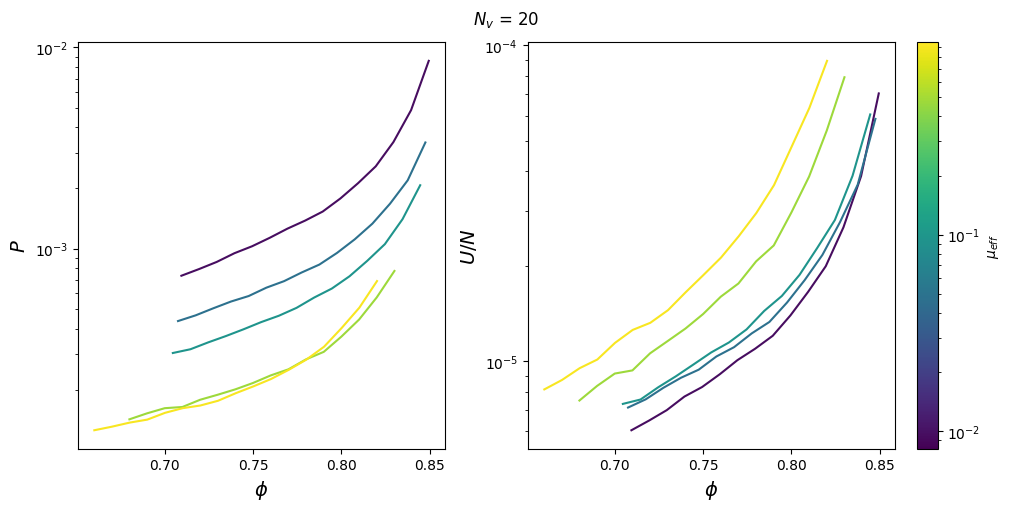

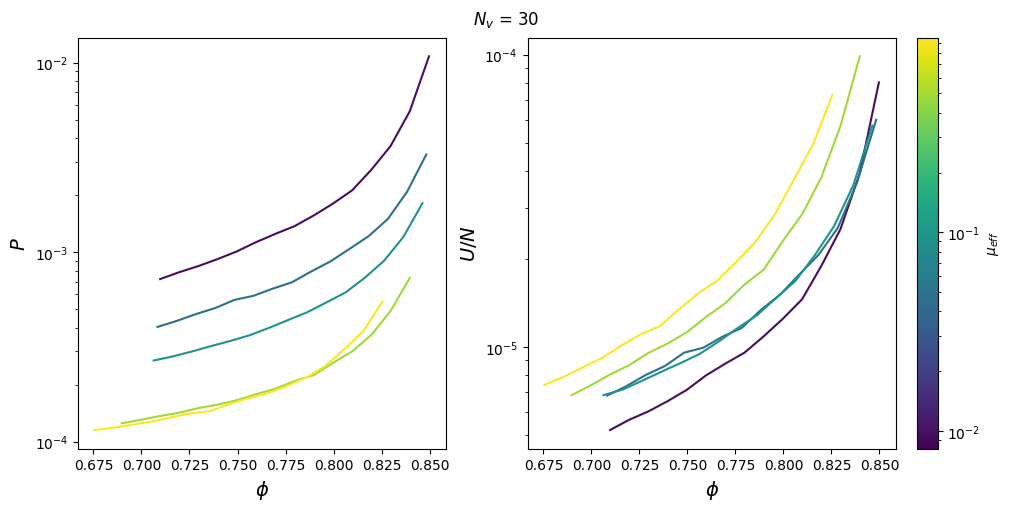

In [155]:
pc = 1e2
oc = 1e-4
cutoff_mask = {}
for n_target in np.unique(z):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True, sharex=True)
    min_inner = np.inf
    for n in np.unique(z):
        for m in np.unique(c):
            if np.any((z == n) & (c == m)):
                if n != n_target:
                    continue
                mask = (z == n) & (c == m) & (o < oc)
                ax[0].plot(x[mask], p[mask], c=cmap(mu_norm(m)))
                ax[1].plot(x[mask], o[mask], c=cmap(mu_norm(m)))
                key = (np.round(m, 10), n)
                if key not in cutoff_mask:
                    cutoff_mask[key] = max(x[mask])
    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_ylabel(r'$P$', fontsize=14)
    ax[1].set_ylabel(r'$U/N$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {n_target - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.unique(mu_eff))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/P_U_NV_{n_target - 1}.png', dpi=300)
    plt.show()
import pickle
with open('cutoff_mask.pkl', 'wb') as f:
    pickle.dump(cutoff_mask, f)


/tmp/ipykernel_2221127/8715916.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(np.max(x[mask]), inner_small[mask][0] / 1.0, c=cmap(mu_norm(m)), marker='s')
/tmp/ipykernel_2221127/8715916.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(np.max(x[mask]), inner_large[mask][0] / 1.4, c=cmap(mu_norm(m)), marker='s')


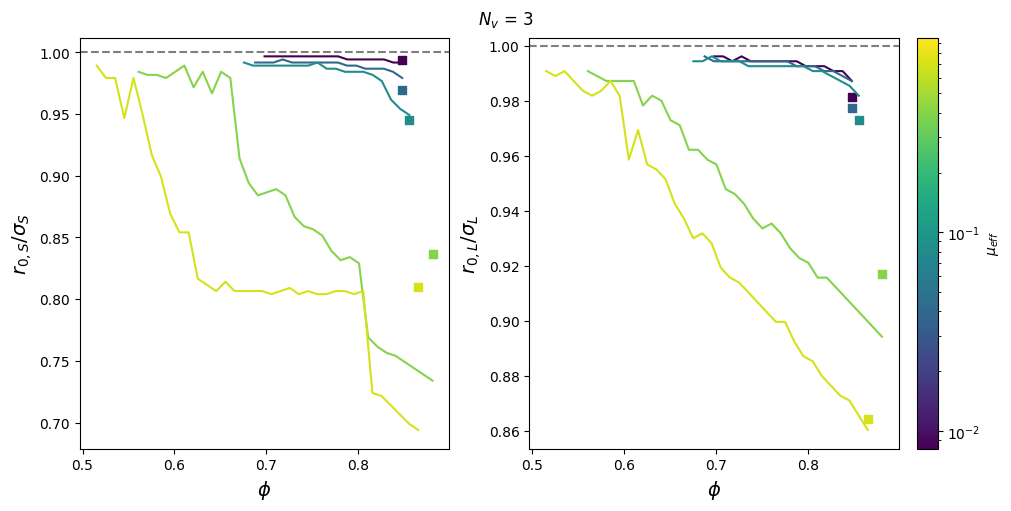

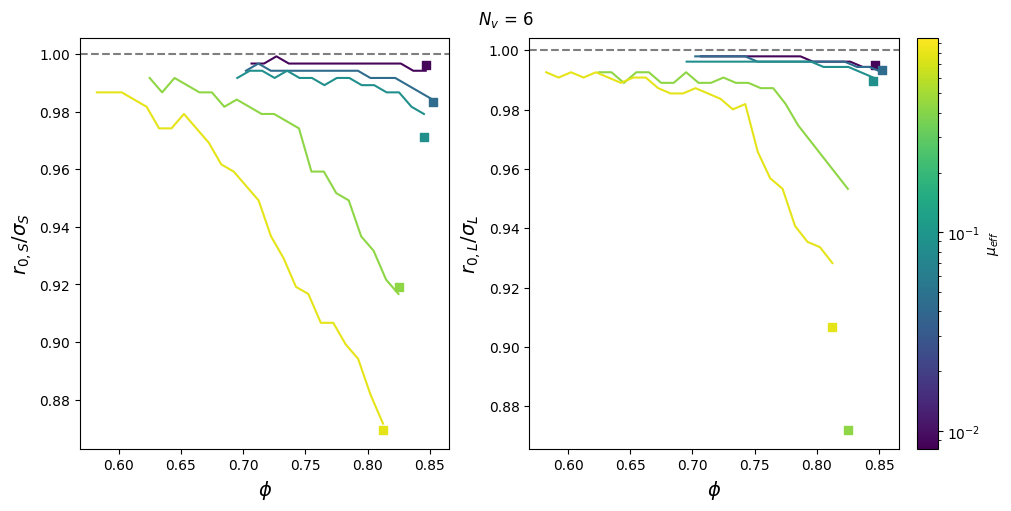

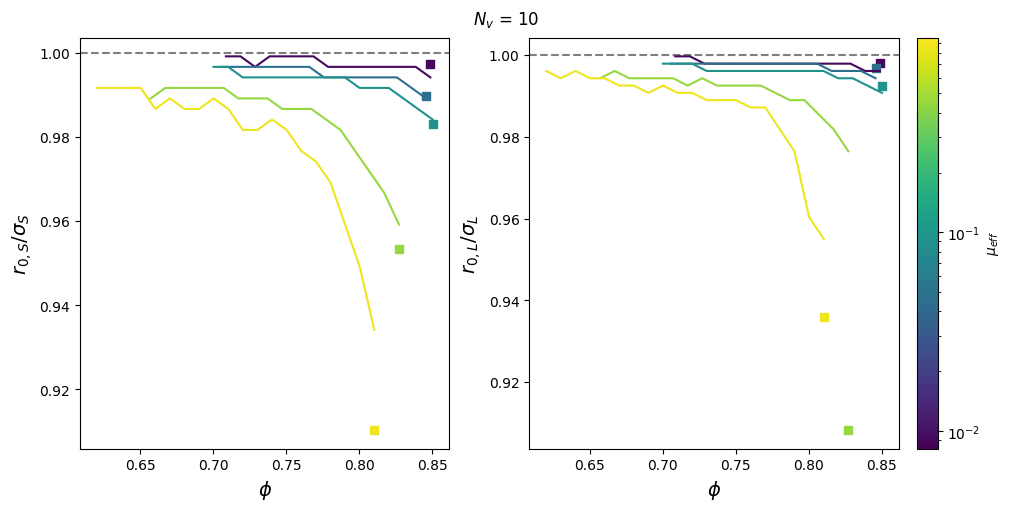

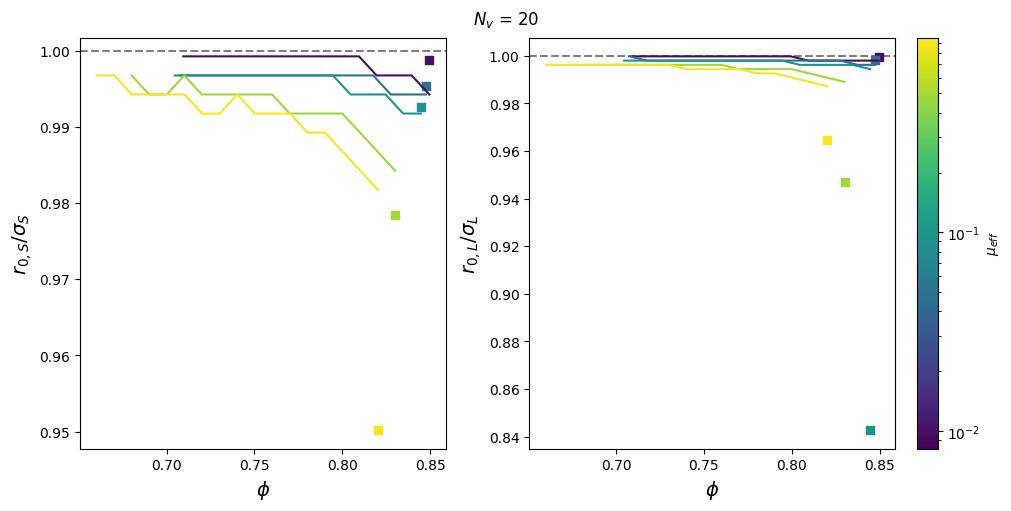

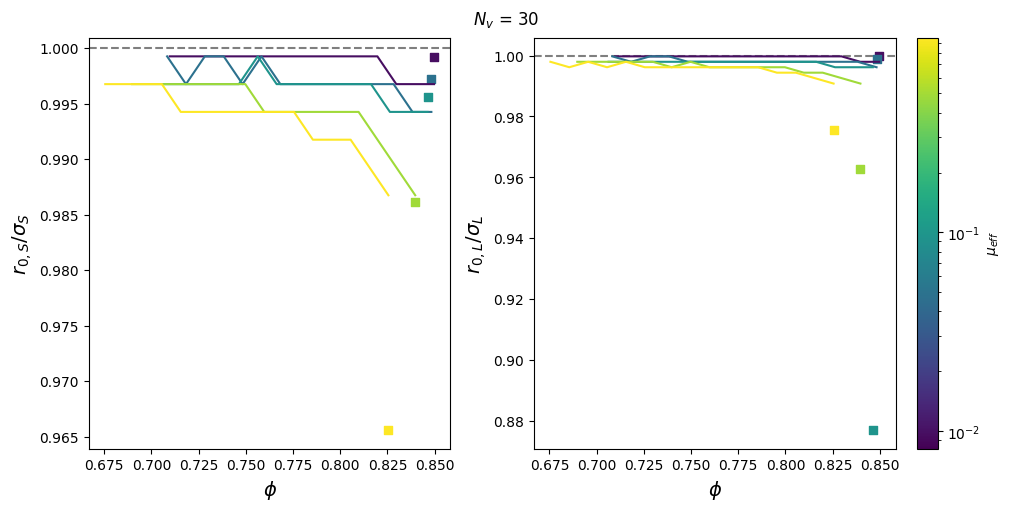

In [84]:
for n_target in np.unique(z):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True, sharex=True)
    min_inner = np.inf
    for n in np.unique(z):
        for m in np.unique(c):
            if np.any((z == n) & (c == m)):
                if n != n_target:
                    continue
                mask = (z == n) & (c == m) & (o < oc)
                min_inner = min(min_inner, y_small[mask].min() / 1.0, y_large[mask].min() / 1.4)
                ax[0].plot(x[mask], y_small[mask] / 1.0, c=cmap(mu_norm(m)))
                ax[1].plot(x[mask], y_large[mask] / 1.4, c=cmap(mu_norm(m)))
                ax[0].scatter(np.max(x[mask]), inner_small[mask][0] / 1.0, c=cmap(mu_norm(m)), marker='s')
                ax[1].scatter(np.max(x[mask]), inner_large[mask][0] / 1.4, c=cmap(mu_norm(m)), marker='s')
                # plt.scatter(np.max(x[mask]), inner[mask][0], c=cmap(mu_norm(m)), marker='s')
                # plt.scatter(x[mask], p[mask], c=cmap(mu_norm(m)))
    for a in ax:
        # a.set_ylim(min_inner * 0.95, 1.05)
        a.axhline(y=1.0, color='k', linestyle='--', zorder=0, alpha=0.5)
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_ylabel(r'$r_{0,S} / \sigma_{S}$', fontsize=14)
    ax[1].set_ylabel(r'$r_{0,L} / \sigma_{L}$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {n_target - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.unique(mu_eff))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/r0_NV_{n_target - 1}.png', dpi=300)
    # THE MARKERS INDICATE THE CLOSEST 0-OVERLAP 2-1 CONTACT - THIS IS NOT THE CLOSEST 0-OVERLAP CONTACT IN GENERAL THOUGH
    # AND IT GETS FURTHER FROM IT AS THE FRICTION INCREASES
    plt.show()

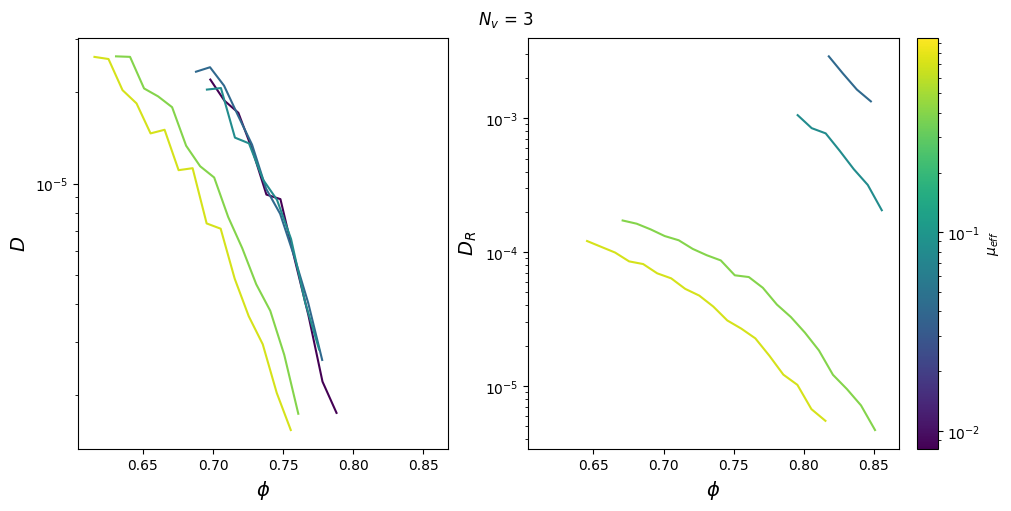

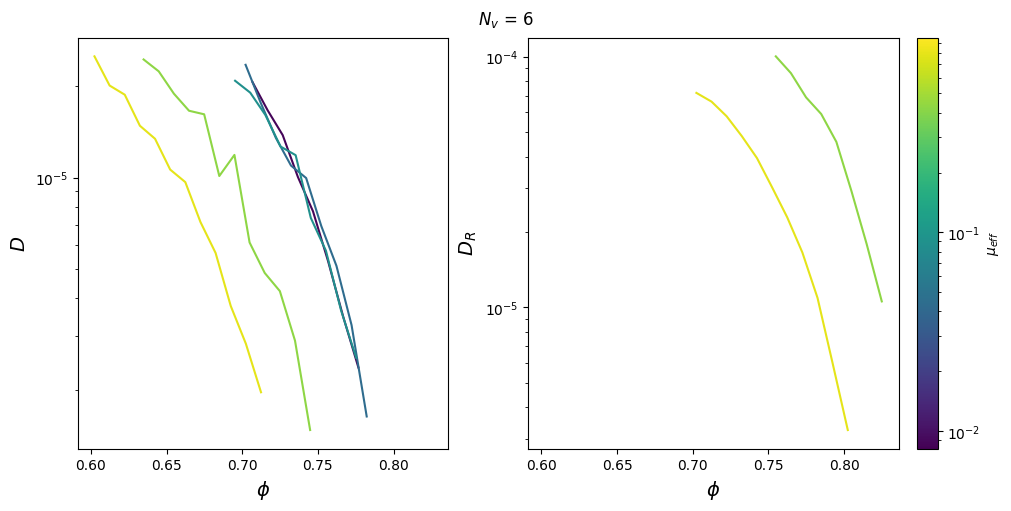

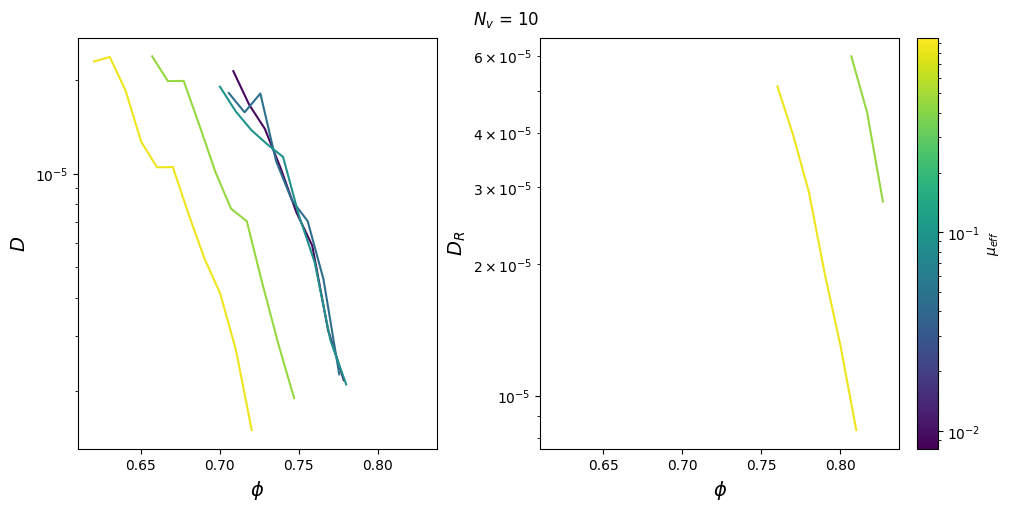

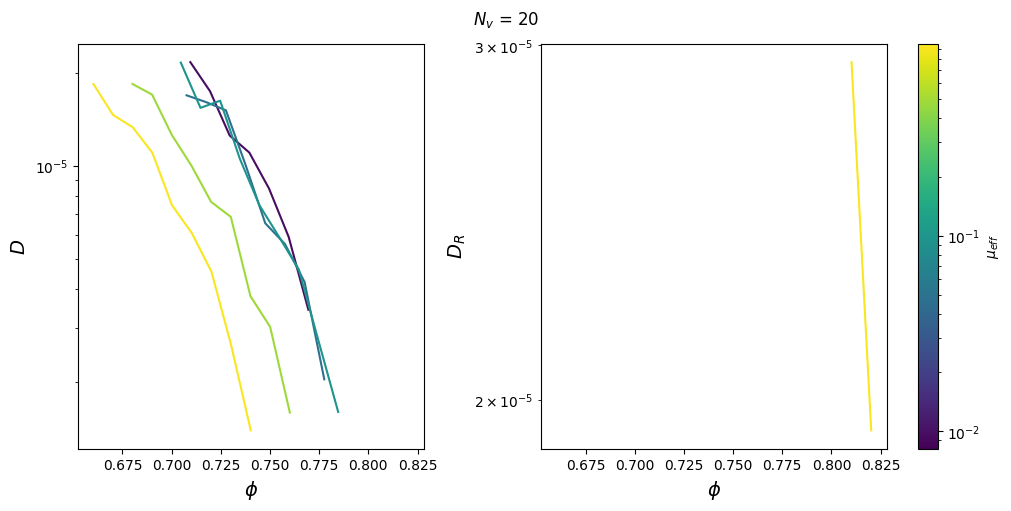

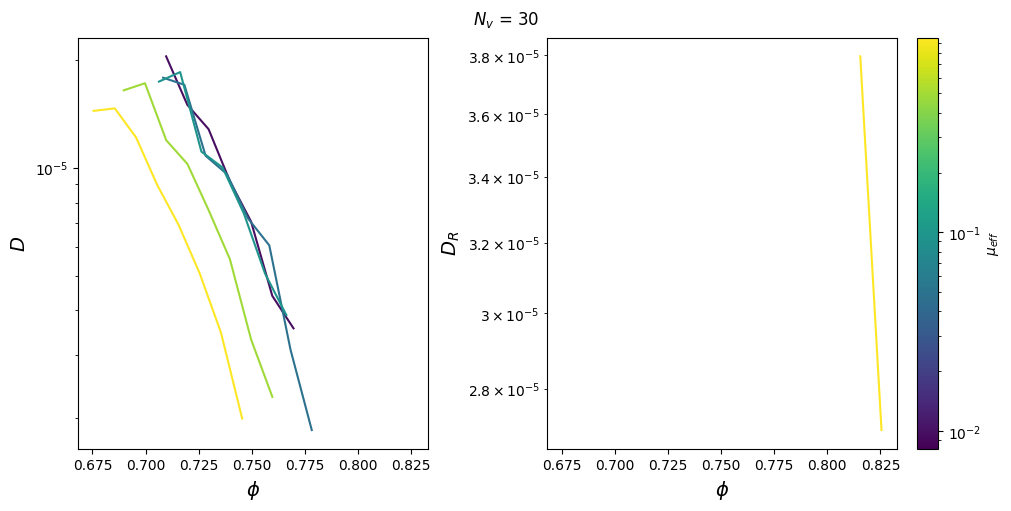

In [148]:
for n_target in np.unique(z):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True, sharex=True)
    min_inner = np.inf
    for n in np.unique(z):
        for m in np.unique(c):
            if np.any((z == n) & (c == m)):
                if n != n_target:
                    continue
                mask = (z == n) & (c == m) & (o < oc)
                ax[0].plot(x[mask], diff[mask], c=cmap(mu_norm(m)))
                ax[1].plot(x[mask], diff_R[mask], c=cmap(mu_norm(m)))
    for a in ax:
        a.set_xlabel(r'$\phi$', fontsize=14)
        a.set_yscale('log')
    ax[0].set_ylabel(r'$D$', fontsize=14)
    ax[1].set_ylabel(r'$D_R$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {n_target - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.unique(mu_eff))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.show()

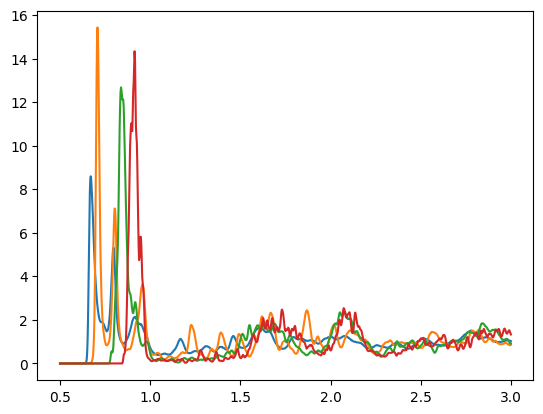

In [88]:
plt.plot(r, G[20, 0])
plt.plot(r, G[15, 0])
plt.plot(r, G[10, 0])
plt.plot(r, G[0, 0])

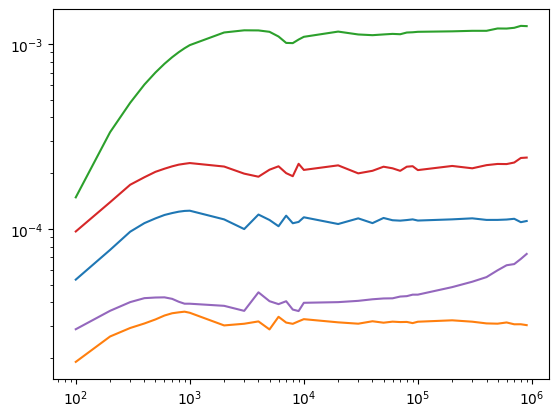

In [86]:
plt.plot(t, msd[:, 0, 0])
plt.plot(t, msd[:, 1, 0])
plt.plot(t, msd[:, 20, 0])
plt.plot(t, msd[:, 21, 0])
plt.plot(t, msd[:, 24, 0])
plt.xscale('log')
plt.yscale('log')

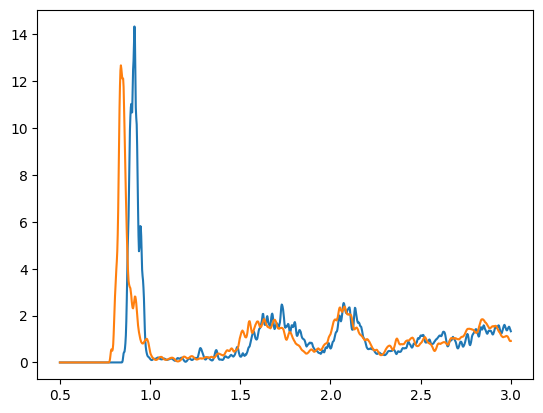

In [87]:
plt.plot(r, G[0, 0])
plt.plot(r, G[10, 0])

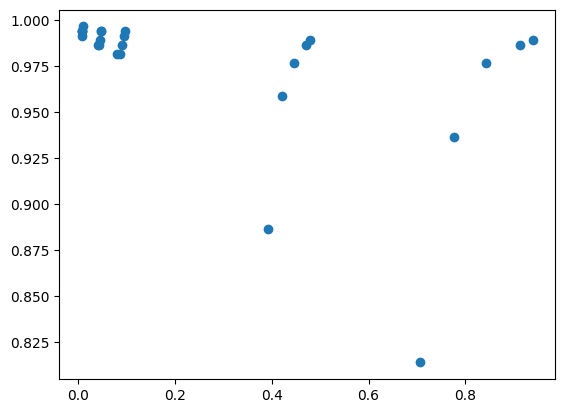

In [10]:
plt.scatter(data.mu_eff[data.system_offset[:-1]], r[np.argmax(G, axis=-1)][:, 0])


In [11]:
data.packing_fraction[24]

np.float64(0.8155302879366072)

(2.0, 5.0)

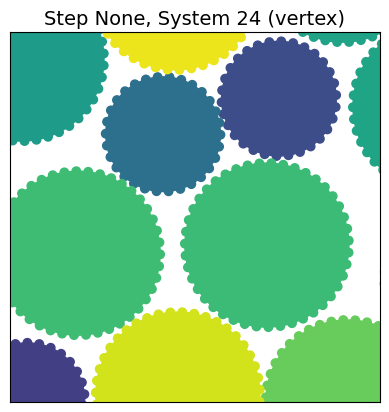

In [215]:
draw_particles_frame(None, plt.gca(), data, 24, True, 'vertex', 'viridis', None)
plt.xlim(2, 5)
plt.ylim(2, 5)

# Solving for temperature where the smallest vertices are only overlapped by 10% gives T=10^-7


# Should probably check other temperatures!

# TODO:

- Queue up runs on bouchet?

- Analyze msd and pair correlations

- Get an answer on the G(t)

- Friction

- Contacts

In [6]:
(1e-2 * data.vertex_rad[data.vertex_system_offset[:-1]].min()) ** 2 / 1e-5

np.float64(0.01184243797237905)

In [22]:
root = "/home/mmccraw/dev/data/09-27-25/run-3/"
data = load(os.path.join(root, "dynamics_1"), location=["final", "init"], load_trajectory=True, load_full=True)

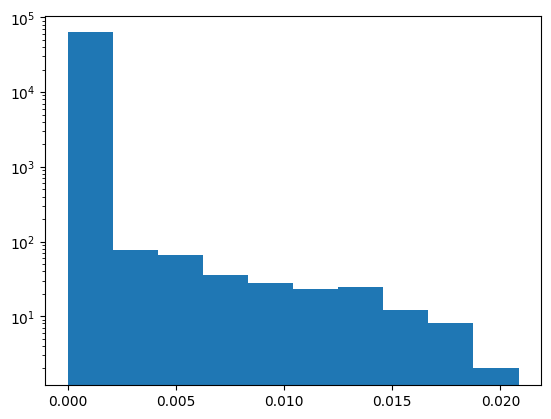

In [43]:
data.trajectory.overlaps.shape

overlaps = data.trajectory.overlaps.copy()
mask = overlaps[:, :, 1] > 0
overlaps[mask, 0] = overlaps[mask, 0] / overlaps[mask, 1]
plt.hist(overlaps[:, :, 0].flatten())
plt.yscale('log')

In [18]:
desired_frames = 100
steps_to_animate = downsample(data, desired_frames)

# Define the output path
output_path = "test.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,  # 15 fps for smooth but not too fast animation
    dpi=150,  # Higher resolution
    bitrate=3000,  # Higher bitrate for better quality
    # Keyword arguments passed to draw_particles_frame
    data=data,
    system_id=1,
    use_pbc=True,
    which='vertex',
    cmap_name='viridis'
)

Creating animation:   3%|▎         | 3/100 [00:00<00:04, 20.82it/s]

Saving animation to test.gif...


Creating animation: 101it [00:10,  9.42it/s]                         

Animation saved successfully!
